In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
from itertools import chain
from numpy import linalg as LA
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import math
import random
import copy
from sklearn.model_selection import cross_val_score, cross_validate, KFold
import lightgbm as lgb
import joblib
import shap
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, confusion_matrix
import scipy.stats as ss

import scipy
import collections


# Load real and synthetic data

In [2]:
# load real data
real_data_df = pd.read_csv('/data/chao/syn_mimic/preprocessing/original_training_data.csv') # note this is the training data for GAN training (not include the test data)
min_max_log = np.load('/data/chao/syn_mimic/preprocessing/min_max_log.npy', allow_pickle=True).item()
# for key, min_max in min_max_log.items():
#     min_, max_ = min_max[0], min_max[1]
#     col_values = np.array(real_data_df[key])
#     real_data_df[key] = (1 - col_values)*max_ + col_values*min_
condition_columns = list(real_data_df.columns)[8:-4]
# real_data_df

In [3]:
min_max_log

{'AGE': [18, 91],
 'BMI': [10.1, 60.0],
 'DIASTOLIC': [30.0, 168.0],
 'SYSTOLIC': [63.0, 243.0]}

In [4]:
print(np.sum(real_data_df['WHITE']))
print(np.sum(real_data_df['BLACK']))
print(np.sum(real_data_df['ASIAN']))
print(np.sum(real_data_df['HISPANIC']))
print(np.sum(real_data_df['UN']))
print(np.sum(real_data_df['OTHER']))
print('Num of y-positive record %d' % np.sum(real_data_df['DIE_1y']))
print('Num of y-negative record %d' % (len(real_data_df) - np.sum(real_data_df['DIE_1y'])))

85133.0
16743.0
5338.0
6945.0
5264.0
7099.0
Num of y-positive record 14243
Num of y-negative record 112279


In [5]:
# load synthetic data
col_name_list = list(real_data_df.columns)
# model_id_list = [11,12,13,14,15]
# ckpt_id_list = [38,38,38,38,38]
model_id_list = [21,22,23,24,25]
ckpt_id_list = ['best','best','best','best','best']
# model_id_list = ['xxx']
# ckpt_id_list = [229]
syn_data_list = []
for model_id, ckpt_id in zip(model_id_list, ckpt_id_list):
    
    syn_data = np.load(f'/data/chao/syn_mimic/GAN_training/syn/emrwgan_model_{model_id}_ckpt_{ckpt_id}.npy', allow_pickle=True)
    for i in range(len(col_name_list)-4):
        syn_data[:,i] = (syn_data[:,i] >= 0.5)*1.0
    syn_data_df = pd.DataFrame(syn_data, columns = col_name_list)
    positive_outcome_syn_data = syn_data_df[syn_data_df['DIE_1y'] == 1.0].values
    negative_outcome_syn_data = syn_data_df[syn_data_df['DIE_1y'] == 0.0].values
    syn_data_df = np.concatenate((positive_outcome_syn_data[:14243,:], negative_outcome_syn_data[:112279,:]), axis=0)
    syn_data_df = pd.DataFrame(syn_data_df, columns = col_name_list)
    
    syn_data_list.append(syn_data_df.values)
    
    
    

In [6]:
syn_data_df

,WHITE,BLACK,ASIAN,HISPANIC,UN,OTHER,DIE_1y,GENDER,008,008.5,...,985,987,988,989,990,994,AGE,BMI,DIASTOLIC,SYSTOLIC
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,84.350143,23.614958,93.114929,123.208267
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,71.803825,27.257238,68.973907,103.245514
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,78.443298,33.419670,70.164368,157.498489
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,85.685913,19.148912,60.110695,87.023987
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,82.278709,19.135632,56.075882,151.215668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126517,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,58.522797,30.887070,61.045025,127.172646
126518,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,39.242012,29.067101,54.062607,101.034927
126519,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,87.370811,30.257900,71.085159,102.389084
126520,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,68.206734,23.069759,64.998894,95.993744


In [7]:
print(np.sum(syn_data_df['WHITE']))
print(np.sum(syn_data_df['BLACK']))
print(np.sum(syn_data_df['ASIAN']))
print(np.sum(syn_data_df['HISPANIC']))
print(np.sum(syn_data_df['UN']))
print(np.sum(syn_data_df['OTHER']))

77817.0
15919.0
6119.0
9755.0
6925.0
9987.0


In [8]:
utility_score = {}
privacy_score = {}

# Data utility evaluation 

## 1. Utility Metrics

### 1.a Dimension-wise distribution

1455


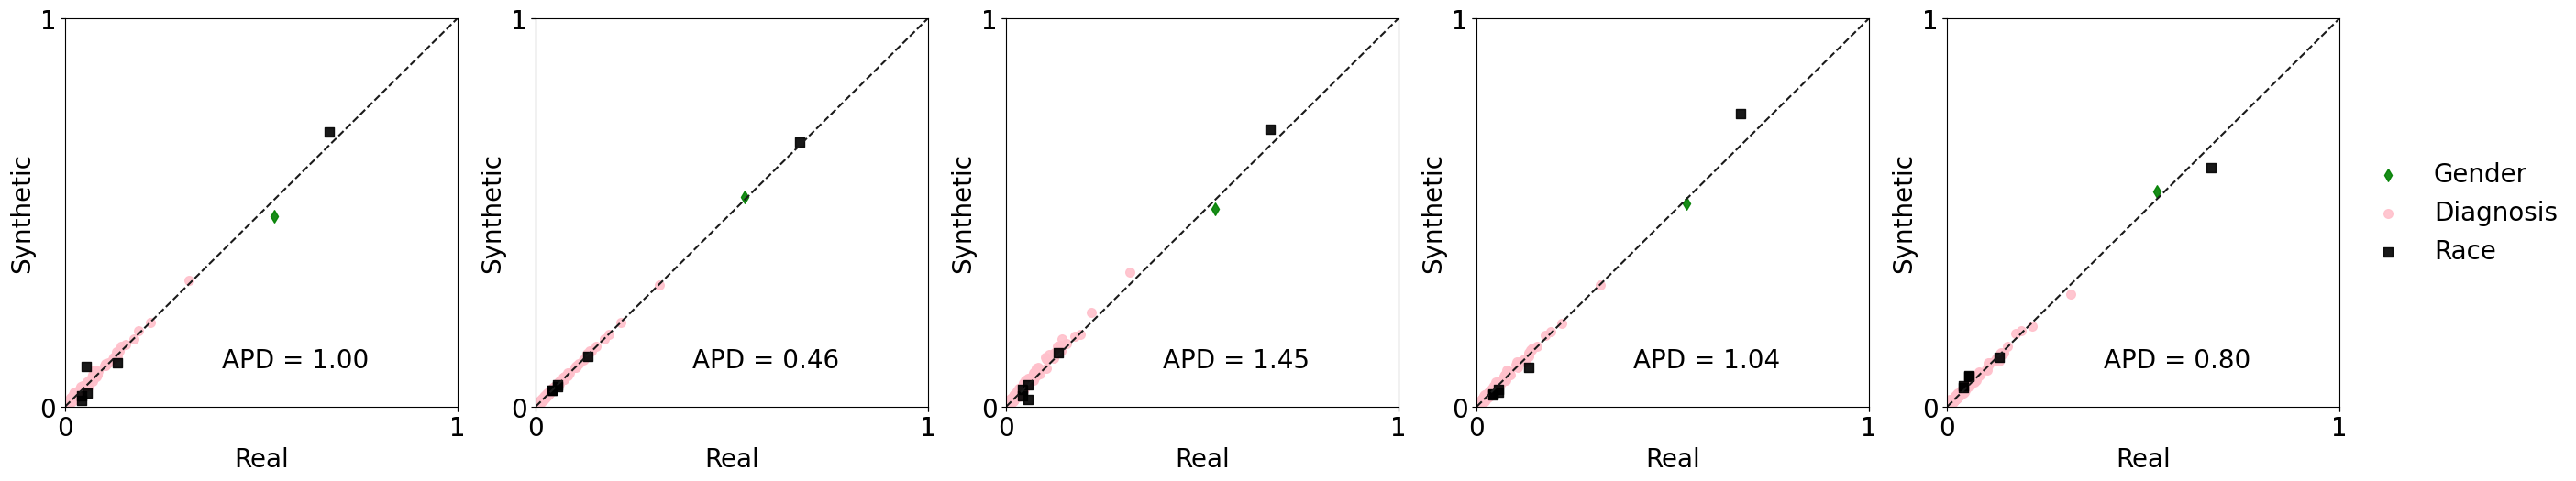

In [9]:
## Dimension-wise distribution: binary features

binary_d2d_average = {}
binary_d2d_sum = {}
binary_perc_real = []
FEATURE_COUNT = len(syn_data_df.columns) - 4
train_data = real_data_df.values
for c in range(0,FEATURE_COUNT):
    if c != 6:
        binary_perc_real.append(np.sum(train_data[:,c])/train_data.shape[0])
print(len(binary_perc_real))

fig, axs = plt.subplots(1, 5, figsize = (32,5.5))
plt.setp(axs, xticks=[0, 1.0, 1],
        yticks=[0, 1.0, 1])

# plt.xticks(fontsize=20)

sd2d_result = []
ad2d_result = []
for run in range(len(syn_data_list)):
    syn_data = syn_data_list[run]
    binary_perc_syn = []

    for c in range(0,FEATURE_COUNT):
        if c != 6:
            binary_perc_syn.append(np.sum(syn_data[:,c])/train_data.shape[0])
    # define categories for features
    cluster_list= np.array([0]*6 + [2] + [1]*len(condition_columns))
    # calculate sd2d for each synthetic data
    sd2d = np.sum(abs(np.array(binary_perc_syn) - np.array(binary_perc_real)))
    ad2d = np.sum(abs(np.array(binary_perc_syn) - np.array(binary_perc_real))) / FEATURE_COUNT * 1000.0 

    for index in [2,1,0]:
        if index == 0:
            marker = "s"
            color = 'black'
            label = 'Race'
        elif index == 1:
            marker = "o"
            color = 'pink'
            label = 'Diagnosis'
        else:
            marker = "d"
            color = 'green'
            label = 'Gender'

        axs[run].scatter(np.array(binary_perc_real)[cluster_list==index], np.array(binary_perc_syn)[cluster_list==index], color = color, s = 48, label=label,marker = marker,alpha=0.9)


    axs[run].set_xlabel("Real", fontsize = 20)
    axs[run].set_ylabel("Synthetic", fontsize = 20)
    axs[run].set_xlim(0, 1)
    axs[run].set_ylim(0, 1)
    axs[run].tick_params(labelsize=20)

    #axs[i,run-1].set_title(f'{syn_list[i]}_{run}', fontsize = 8)
    axs[run].plot([0, 1], [0, 1], ls="--", c=".1")
    axs[run].text(0.4, 0.10, f'APD = {ad2d:.2f}', fontsize = 20)
    sd2d_result.append(sd2d)
    ad2d_result.append(ad2d)

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15, frameon=False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20, frameon=False)
plt.show()
# fig.savefig('./gan_com_5run_vumc_0630.eps',bbox_inches='tight',format='eps') 



In [10]:
sd2d_result

[1.4544506093801868,
 0.6742226648329936,
 2.1091272664042617,
 1.5138869129479458,
 1.16013815779074]

18.0
91.0
10.1
60.0
30.0
168.0
63.0
243.0

 AGE


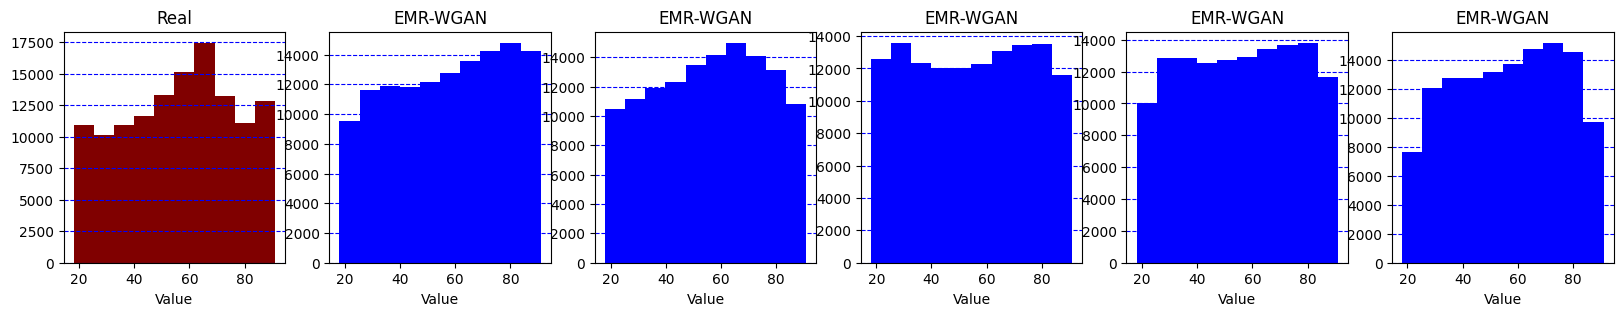

EMR-WGAN : mean: 1.2186, std: 0.3797

 BMI


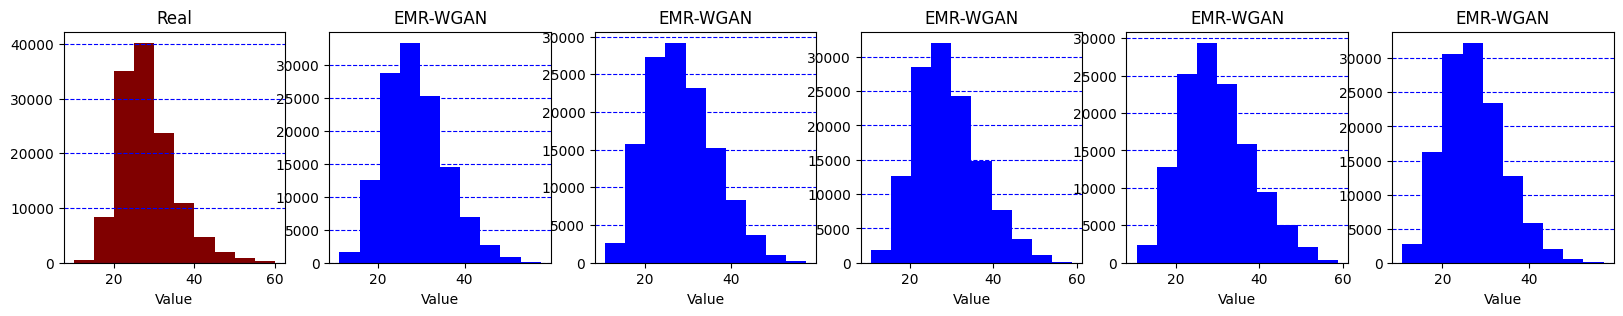

EMR-WGAN : mean: 1.2033, std: 0.3995

 DIASTOLIC


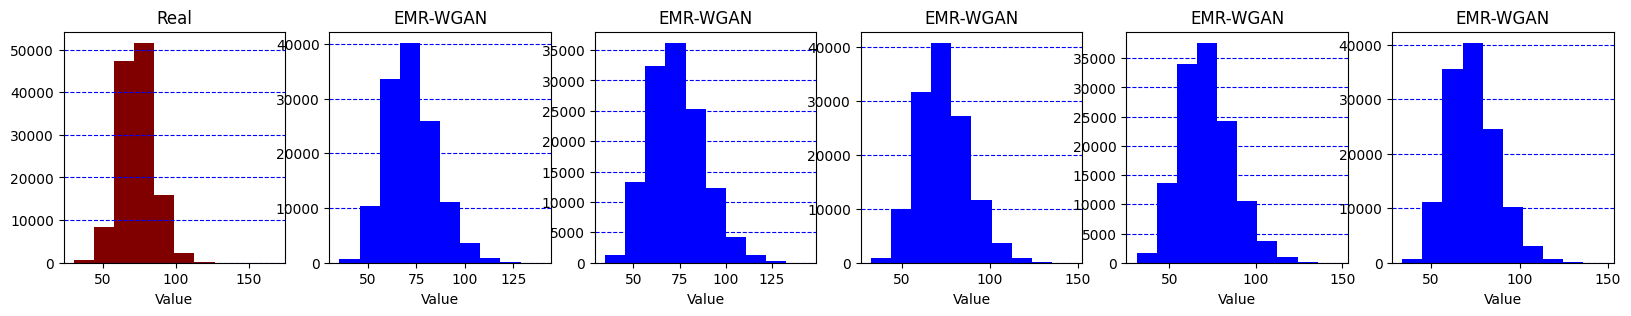

EMR-WGAN : mean: 2.5176, std: 0.7013

 SYSTOLIC


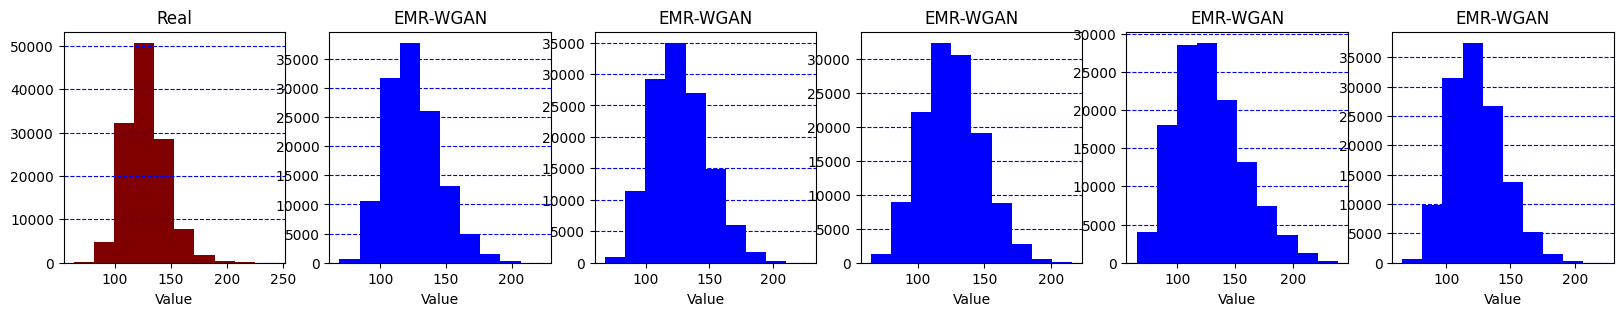

EMR-WGAN : mean: 4.5150, std: 2.4592
{'AGE': [1.1937850705457331, 0.7299580089291527, 1.8845565517790546, 1.2572501878685198, 1.0272469898128063], 'BMI': [0.6790634877678603, 1.154722648992723, 1.154076944843463, 1.917514544873061, 1.111290351130316], 'DIASTOLIC': [1.8886651485516257, 2.645264896888435, 2.1384315854337284, 3.828403435890693, 2.087041844456488], 'SYSTOLIC': [2.606737967817816, 3.4336466856556522, 3.5545387166157845, 9.380067745509097, 3.6001272879471315]}


In [11]:
## Dimension-wise distribution: continuous features

print(np.min(list(real_data_df['AGE'])))
print(np.max(list(real_data_df['AGE'])))

print(np.min(list(real_data_df['BMI'])))
print(np.max(list(real_data_df['BMI'])))

print(np.min(list(real_data_df['DIASTOLIC'])))
print(np.max(list(real_data_df['DIASTOLIC'])))

print(np.min(list(real_data_df['SYSTOLIC'])))
print(np.max(list(real_data_df['SYSTOLIC'])))

continuous_w_d = {}
continuous_columns = ['AGE', 'BMI', 'DIASTOLIC', 'SYSTOLIC']

RUN_list = [1,2,3,4,5]

for column in continuous_columns:
    distances_to_real = []

    model_list_figure = ['Real']
    real_values = list(real_data_df[column])
    data_list = [real_values]
    color_list = ['maroon']
    for run in RUN_list:
        emrwgan_df = pd.DataFrame(syn_data_list[run-1], columns = list(real_data_df.columns))
        data_list.append(list(emrwgan_df[column]))
        color_list.append('blue')
        model_list_figure.append('EMR-WGAN')
    
    fig = plt.figure(figsize=(20, 3))
    
    print('\n %s' % column)
    for subplot_count in range(len(data_list)):
        
        if subplot_count > 0:
            distances_to_real.append(wasserstein_distance(real_values, data_list[subplot_count]))
        
        plt.subplot(1, 6, subplot_count+1)
        # fig = plt.figure(figsize = (3, 5))
        plt.hist(data_list[subplot_count], color = color_list[subplot_count])
        plt.xlabel("Value")
#         plt.ylim(0, 10000)
        plt.title(model_list_figure[subplot_count])
        plt.grid(color = 'blue', linestyle = '--', axis = 'y')

    plt.show()
    print("EMR-WGAN : mean: %.4f, std: %.4f" % (np.mean(distances_to_real), np.std(distances_to_real)))

    continuous_w_d[column] = distances_to_real
print(continuous_w_d)

In [12]:
continuous_value = {}
norm_continuous_value = {}
    
for test, w_d in continuous_w_d.items():
    w_d = list(w_d)
    max_val = np.max(w_d)
    min_val = np.min(w_d)
    norm_w_d = (w_d - min_val) / (max_val-min_val) / 10
    continuous_value[test] = w_d
    norm_continuous_value[test] = list(norm_w_d)
    
continuous_value_df = pd.DataFrame.from_dict(continuous_value)
norm_continuous_value_df = pd.DataFrame.from_dict(norm_continuous_value)
sum_all_continuous_variables = np.sum(norm_continuous_value_df.values, axis = 1)
print(sum_all_continuous_variables)
norm_continuous_value_df

[0.04017215 0.08962114 0.16522487 0.34566888 0.08554203]


,AGE,BMI,DIASTOLIC,SYSTOLIC
0,0.040172,0.000000,0.000000,0.000000
1,0.000000,0.038408,0.039005,0.012208
2,0.100000,0.038355,0.012876,0.013993
3,0.045669,0.100000,0.100000,0.100000
4,0.025748,0.034901,0.010227,0.014666


In [13]:
combine_score_binary_cont = []
for run in RUN_list:
    combine_score_binary_cont.append((sd2d_result[run-1] + sum_all_continuous_variables[run-1])/(len(real_data_df.columns)-1) * 1000)

print('Dimension-wise distribution scores for all considered runs:', combine_score_binary_cont)
utility_score['Dimension-wise distribution'] = combine_score_binary_cont



Dimension-wise distribution scores for all considered runs: [1.024415873644543, 0.5235392767153383, 1.5588431385697294, 1.2745413222278763, 0.8537903943627151]


### 1.b Column-wise correlation

In [14]:
real_cor = np.corrcoef(np.transpose(train_data))
cwc = []
print("Column-wise correlation difference: \n")
for matrix in syn_data_list:
    np.random.seed(0)
    noise_matrix = (np.random.rand(len(matrix),len(matrix[0])) - 1) / 100000000    
    syn_cor = np.corrcoef(np.transpose(np.array(matrix) + noise_matrix))
    cwc.append(LA.norm(real_cor - syn_cor, 'fro') / len(real_data_df.columns) / len(real_data_df.columns) * 1000 * 1000)

print(cwc)
utility_score['Column-wise correlation'] = cwc


Column-wise correlation difference: 

[5.800565453515808, 5.4226583129816746, 5.9071028272186075, 6.3210266094586265, 6.315851456601387]


In [15]:
syn_data_list[0][0]

array([  1.      ,   0.      ,   0.      , ...,  25.405653,  75.980865,
       144.44333 ], dtype=float32)

### 1.c Latent cluster analysis

In [16]:
min_max_scaler = preprocessing.MinMaxScaler()
train_data_tmp = copy.deepcopy(train_data)
train_data_df = pd.DataFrame(train_data_tmp)
train_data_df.loc[:,[1456, 1457, 1458, 1459]] = min_max_scaler.fit_transform(train_data_df[[1456, 1457, 1458, 1459]].values)
NUM_C = 5 ## the number of clusters which has been optimized


In [17]:
real_data_df

,WHITE,BLACK,ASIAN,HISPANIC,UN,OTHER,DIE_1y,GENDER,008,008.5,...,985,987,988,989,990,994,AGE,BMI,DIASTOLIC,SYSTOLIC
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,91.0,35.3,104.0,144.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,86.0,24.1,47.0,107.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,55.0,39.0,75.0,112.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18.0,23.0,70.0,128.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,43.0,22.3,50.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126517,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,56.0,21.5,70.0,106.0
126518,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,37.0,20.0,68.0,103.0
126519,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,64.0,33.4,94.0,139.0
126520,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,91.0,17.2,70.0,110.0


In [18]:
max(real_data_df['AGE'])

91.0

In [19]:
log_cluster_score_list = []
print("Latent deviation: \n")
for matrix in syn_data_list:
    matrix_df = pd.DataFrame(copy.deepcopy(matrix))
    matrix_df.loc[:,[1456, 1457, 1458, 1459]] = min_max_scaler.fit_transform(matrix_df[[1456, 1457, 1458, 1459]].values)
    mixed_data = np.concatenate((train_data_df.values,matrix_df.values), axis = 0)
    pca = PCA()
    pca_result = pca.fit_transform(mixed_data)
    sum_diag = np.sum(pca.explained_variance_ratio_)
    i = 1
    while  np.sum(pca.explained_variance_ratio_[:i]) < 0.8:
        i += 1
#     print(i, np.sum(pca.explained_variance_ratio_[:i])/np.sum(pca.explained_variance_ratio_))
    pca = PCA(n_components=i)
    pca_result = pca.fit_transform(mixed_data)
    
    kmeans_model = KMeans(n_clusters=NUM_C).fit(pca_result)
    cluster_aff = kmeans_model.labels_.tolist()
    real_syn_label = [1]*len(train_data_df.values) + [0]*len(matrix_df.values)
    
    cluster_score_sum = 0
    for label in range(NUM_C):
        indices_label = [i for i in range(len(cluster_aff)) if cluster_aff[i] == label]
        real_syn_for_label = [real_syn_label[i] for i in indices_label]
        ratio = np.sum(real_syn_for_label)/len(real_syn_for_label)
        cluster_score_sum += (ratio - 0.5)**2
    log_cluster_score_list.append(math.log2(cluster_score_sum/NUM_C))
print(log_cluster_score_list)
utility_score['Latent cluster analysis'] = log_cluster_score_list


Latent deviation: 

[-11.098742322050022, -15.663163969433555, -9.92536962270512, -8.358865094374572, -9.372114175598648]


### 1.d Medical concept abundance

Medical concept abundance distances: [0.046229114304231676, 0.026556646274956134, 0.06971910023553216, 0.05911224925309432, 0.022557341806168096]


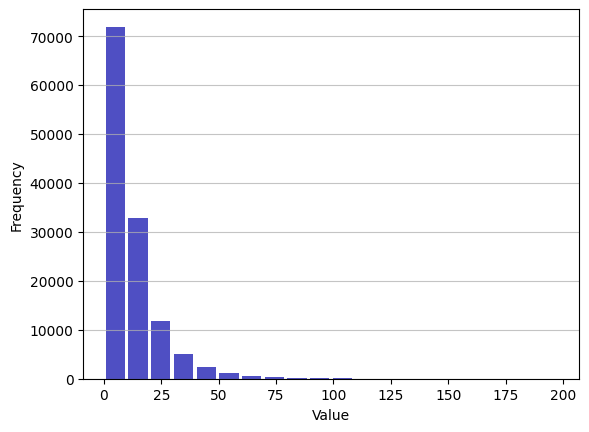

In [20]:
mca_train_data_df = real_data_df[condition_columns]
mca_train_data = np.sum(mca_train_data_df.values, axis=1)
n, bins, patches = plt.hist(x=mca_train_data, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')

mca_syn_data_list = []

for matrix in syn_data_list:
    syn_data_df = pd.DataFrame(data = matrix, columns = list(real_data_df.columns))
    mca_syn_data_df = syn_data_df[condition_columns]
    mca_syn_data = np.sum(mca_syn_data_df.values, axis=1).astype(int)
    count_in_bins = {}

    bin_counts = [0]*len(n) 
    for data_point in mca_syn_data:
        bin_number = data_point // (bins[1]-bins[0])
        if bin_number >= len(n):
            bin_counts[-1] += 1
        else:
            bin_counts[int(bin_number)] += 1

    mca_syn_data_list.append(np.sum(np.abs(np.array(bin_counts)-n))*0.5/len(mca_train_data))

print("Medical concept abundance distances:", mca_syn_data_list)
utility_score['Medical concept abundance'] = mca_syn_data_list


### 1.e Clinical knowledge violation

In [21]:
disease_male_dict = {}
disease_female_dict = {}

gender_column = real_data_df['GENDER'].tolist()
for column in condition_columns:
    disease_column = real_data_df[column].tolist()
    patient_positive = [index for index in range(len(disease_column)) if disease_column[index] == 1]
    gender_positive_patient = [gender_column[index] for index in patient_positive]
    if np.sum(gender_positive_patient) == 0: # male
        disease_male_dict[column] = len(patient_positive)
    if np.sum(gender_positive_patient) == len(gender_positive_patient): # female
        disease_female_dict[column] = len(patient_positive)

    
sorted_disease_female_dict = sorted(disease_female_dict.items(), key=lambda kv: kv[1], reverse=True)
sorted_disease_male_dict = sorted(disease_male_dict.items(), key=lambda kv: kv[1], reverse=True)

In [22]:
# male: 600: Hyperplasia of prostate
# male: 185: Cancer of prostate
# male: 605: Erectile dysfunction [ED]

# female: 649: Other conditions or status of the mother complicating pregnancy, childbirth, or the puerperium
# female: 655: Known or suspected fetal abnormality affecting management of mother
# female: 646: Other complications of pregnancy NEC

print('    Male codes: ')
for code in ['600', '185', '605']:
    disease_column = real_data_df[code].tolist()
    patient_positive = [index for index in range(len(disease_column)) if disease_column[index] == 1]
    gender_column = real_data_df['GENDER'].tolist()
    gender_positive_patient = [gender_column[index] for index in patient_positive]
    print('       ' + code + ': # total patients = ' + str(np.sum(disease_column)) + '; male percentage: ' + str((len(gender_positive_patient) - np.sum(gender_positive_patient))/len(gender_positive_patient)) + '; female percentage: ' + str(np.sum(gender_positive_patient)/len(gender_positive_patient)))

print('    Female codes: ')
for code in ['649', '655', '646']:
    disease_column = real_data_df[code].tolist()
    patient_positive = [index for index in range(len(disease_column)) if disease_column[index] == 1]
    gender_column = real_data_df['GENDER'].tolist()
    gender_positive_patient = [gender_column[index] for index in patient_positive]
    print('       ' + code + ': # total patients = ' + str(np.sum(disease_column)) + '; male percentage: ' + str((len(gender_positive_patient) - np.sum(gender_positive_patient))/len(gender_positive_patient)) + '; female percentage: ' + str(np.sum(gender_positive_patient)/len(gender_positive_patient)))


    Male codes: 
       600: # total patients = 4392.0; male percentage: 1.0; female percentage: 0.0
       185: # total patients = 2694.0; male percentage: 1.0; female percentage: 0.0
       605: # total patients = 364.0; male percentage: 1.0; female percentage: 0.0
    Female codes: 
       649: # total patients = 4182.0; male percentage: 0.0; female percentage: 1.0
       655: # total patients = 3617.0; male percentage: 0.0; female percentage: 1.0
       646: # total patients = 2236.0; male percentage: 0.0; female percentage: 1.0


In [23]:
run = 1
male_code_violation = []
female_code_violation = []
for matrix in syn_data_list:
    syn_data_df = pd.DataFrame(data = matrix, columns = list(real_data_df.columns))
    print('\nSynthetic data ' + str(run) + ':')
    print('    Male codes: ')
    male_viol_sum = 0
    for code in ['600', '185', '605']:
        disease_column = syn_data_df[code].tolist()
        patient_positive = [index for index in range(len(disease_column)) if disease_column[index] == 1]
        gender_column = syn_data_df['GENDER'].tolist()
        gender_positive_patient = [gender_column[index] for index in patient_positive]
        print('       ' + code + ': # total patients = ' + str(np.sum(disease_column)) + '; male percentage: ' + str((len(gender_positive_patient) - np.sum(gender_positive_patient))/len(gender_positive_patient)) + '; female percentage: ' + str(np.sum(gender_positive_patient)/len(gender_positive_patient)))
        male_viol_sum += np.sum(gender_positive_patient)/len(gender_positive_patient)
    male_code_violation.append(male_viol_sum/3)
    
    print('    Female codes: ')
    female_viol_sum = 0
    for code in ['649', '655', '646']:
        disease_column = syn_data_df[code].tolist()
        patient_positive = [index for index in range(len(disease_column)) if disease_column[index] == 1]
        gender_column = syn_data_df['GENDER'].tolist()
        gender_positive_patient = [gender_column[index] for index in patient_positive]
        print('       ' + code + ': # total patients = ' + str(np.sum(disease_column)) + '; male percentage: ' + str((len(gender_positive_patient) - np.sum(gender_positive_patient))/len(gender_positive_patient)) + '; female percentage: ' + str(np.sum(gender_positive_patient)/len(gender_positive_patient)))
        female_viol_sum += (len(gender_positive_patient) - np.sum(gender_positive_patient))/len(gender_positive_patient)
    female_code_violation.append(female_viol_sum/3)
    
    run += 1
    
utility_score['Clinical knowledge violation'] = np.array(male_code_violation) + np.array(female_code_violation)
print('Clinical knowledge violation: male code violation ', male_code_violation, 'female code violation ', female_code_violation)
print('Combined violation: ', np.array(male_code_violation) + np.array(female_code_violation))



Synthetic data 1:
    Male codes: 
       600: # total patients = 4905.0; male percentage: 0.9504587155963303; female percentage: 0.04954128440366973
       185: # total patients = 2949.0; male percentage: 0.9494743981010512; female percentage: 0.050525601898948794
       605: # total patients = 439.0; male percentage: 0.9840546697038725; female percentage: 0.015945330296127564
    Female codes: 
       649: # total patients = 4362.0; male percentage: 0.0032095369096744614; female percentage: 0.9967904630903255
       655: # total patients = 4068.0; male percentage: 0.004670599803343166; female percentage: 0.9953294001966568
       646: # total patients = 2741.0; male percentage: 0.005472455308281649; female percentage: 0.9945275446917183

Synthetic data 2:
    Male codes: 
       600: # total patients = 4454.0; male percentage: 0.9470139200718455; female percentage: 0.05298607992815447
       185: # total patients = 2790.0; male percentage: 0.9139784946236559; female percentage: 0.08

### 1.f TSTR

In [24]:
## Train on real training dataset and test on real testing data set

random.seed(a=2021, version=2)

RECALL_THRESHOLD = 0.6  # hold this to compute other threshold related metrics
LABEL_INDEX = 6  # label column index in the dataset
RACE_COL = [0,1,2,3,4,5]
COL_LIST = list(real_data_df.columns)[len(RACE_COL)+1:]
CAT_IDX_wo_RACE_label = list(np.linspace(0, len(COL_LIST) - 5, num=len(COL_LIST) - 4).astype(int))

## Load the dataset for model training. Here it is real data. 70%
train_real_data = pd.read_csv('/data/chao/syn_mimic/preprocessing/original_training_data.csv').values.astype(np.float)
train_real_data_index = np.linspace(0,len(train_real_data)-1,len(train_real_data)).astype('int')
random.shuffle(train_real_data_index)
train_real_data = train_real_data[train_real_data_index]
train_real_label = train_real_data[:,LABEL_INDEX].astype(np.float)
train_real_data = np.delete(train_real_data, [LABEL_INDEX]+RACE_COL, axis = 1)
print('The number of records in training (real) data is:  %d' % len(train_real_data))
print('The number of features in training (real) data is:  %d' % len(train_real_data[0]))
print('Positive vs Negative ratio in training (real) data is: %f' % (np.sum(train_real_label)/len(train_real_label)))

## load the dataset for model evaluation. Here it is real data. 30%
eval_real_data = pd.read_csv('/data/chao/syn_mimic/preprocessing/original_testing_data.csv').values.astype(np.float)
eval_real_label = eval_real_data[:,LABEL_INDEX].astype(np.float)
eval_real_data = np.delete(eval_real_data, [LABEL_INDEX]+RACE_COL, axis=1)
print('\nThe number of records in evaluation (real) data is: %d' % len(eval_real_data))
print('The number of features in training (real) data is: %d' % len(eval_real_data[0]))
print('Positive vs Negative ratio in evaluation (real) data is: %f' % (np.sum(eval_real_label)/len(eval_real_label)))

## model training
print('\n !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! ')

gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_real_data, y=train_real_label)


# ############
# # try some candidates here

# param_grid = {
#             'n_estimators': [500,1000],
#             'colsample_bytree': [0.8,0.9],
#             'max_depth': [15,20],
#             'num_leaves': [50,80],
#             'reg_alpha': [1.1, 1.3],
#             'min_split_gain': [0.3, 0.5],
#             'subsample': [0.6, 0.9],
#             'subsample_freq': [20, 40]
#             }
############

param_grid = {
            'n_estimators': [500],
            'colsample_bytree': [0.9],
            'max_depth': [15],
            'num_leaves': [50],
            'reg_alpha': [1.3],
            'min_split_gain': [0.3],
            'subsample': [0.9],
            'subsample_freq': [40]
            }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 20)
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
gbm = gsearch.fit(X=train_real_data, y=train_real_label)
print("Best parameters:\n")
print(gbm.best_params_)

y_scores = gbm.predict_proba(eval_real_data)
y_scores = y_scores[:,1]
trtr_7_3_auroc = roc_auc_score(y_score=y_scores, y_true=eval_real_label)
trtr_prauc = average_precision_score(eval_real_label, y_scores)
fpr, tpr, threshold_candidate = roc_curve(eval_real_label, y_scores)
thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
thres = threshold_candidate[thres_index]
print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

tn, fp, fn, tp = confusion_matrix(eval_real_label, pred_y).ravel()
trtr_ppv = tp / (tp + fp)
trtr_npv = tn / (tn + fn)
trtr_sens = tp / (tp + fn)
trtr_spes = tn / (tn + fp)
trtr_acc = (tn + tp) / (tn + fp + fn + tp)
print("      *** Test on real data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
trtr_7_3_auroc, trtr_prauc, trtr_acc, trtr_ppv, trtr_npv, trtr_sens, trtr_spes))

explainer = shap.TreeExplainer(gbm.best_estimator_)
shap_df = pd.DataFrame(explainer.shap_values(eval_real_data)[1], columns = COL_LIST)
shap_df_abs = abs(shap_df)

feature_importance_mean = shap_df_abs.mean(axis=0).sort_values(ascending=False)
feature_importance_value = {}
for key, value in feature_importance_mean.items():
    if key in feature_importance_value.keys():
        feature_importance_value[key].append(value)
    else:
        feature_importance_value[key] = [value]

correlation_coeff_value = {}
for key in COL_LIST:
    corr_value = np.corrcoef(shap_df[key], eval_real_data[:, COL_LIST.index(key)])[1][0]
    if key in correlation_coeff_value.keys():
        correlation_coeff_value[key].append(corr_value)
    else:
        correlation_coeff_value[key] = [corr_value]
        
np.save('./result/feature_importance_TRTR.npy', feature_importance_value)

# np.save('./result/r_70_train_r_30_test_correl_coeff_value.npy', correlation_coeff_value)
# shap_df.to_csv('./result/r_70_train_r_30_test_feature_importance.csv')
# np.save('./result/r_70_train_r_30_test_y_estimate.npy', y_scores)
# np.save('./result/r_70_train_r_30_test_y_label.npy', eval_real_label)
# joblib.dump(gbm.best_estimator_, './result/r_70_train_r_30_test.pkl')

print('TRTR AUROC: %.4f' % trtr_7_3_auroc)
print('TRTR AUPRC: %.4f' % trtr_prauc)
print('TRTR ACCURACY: %.4f' % trtr_acc)
print('TRTR PPV: %.4f' % trtr_ppv)
print('TRTR NPV: %.4f' % trtr_npv)
print('TRTR RECALL: %.4f' % trtr_sens)
print('TRTR SPESIFICITY: %.4f' % trtr_spes)


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The number of records in training (real) data is:  126522
The number of features in training (real) data is:  1453
Positive vs Negative ratio in training (real) data is: 0.112573


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



The number of records in evaluation (real) data is: 54224
The number of features in training (real) data is: 1453
Positive vs Negative ratio in evaluation (real) data is: 0.113806

 !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
Threshold for fixing recall as 0.60 is 0.3743
      *** Test on real data AUROC: 0.9227, PRAUC: 0.6366, ACC: 0.9109, PPV: 0.6105, NPV: 0.9488, Sensitivity: 0.6001, Specificity: 0.9508


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide


TRTR AUROC: 0.9227
TRTR AUPRC: 0.6366
TRTR ACCURACY: 0.9109
TRTR PPV: 0.6105
TRTR NPV: 0.9488
TRTR RECALL: 0.6001
TRTR SPESIFICITY: 0.9508


In [25]:
feature_importance_value


{'AGE': [0.8599036160698073],
 'GENDER': [0.14144107957052665],
 '198': [0.13944815665546306],
 '585': [0.120783652571564],
 '285': [0.08350772652484546],
 'BMI': [0.06972117472994824],
 'SYSTOLIC': [0.06760910589163174],
 '428': [0.06641600001741439],
 '316': [0.06063787304320788],
 '591': [0.06018638166751106],
 '496': [0.05957995772543179],
 '317': [0.05597536126870043],
 '480': [0.05525453156347566],
 '272.1': [0.05375843485341222],
 '272': [0.053397836425737935],
 '318': [0.04896546034946632],
 '276': [0.046196632348661934],
 '401.1': [0.04615567268770498],
 '411': [0.04547399210645627],
 '707': [0.043276474107083136],
 '290': [0.043095985857801354],
 '260': [0.04179908526528575],
 '348': [0.03962593439894705],
 '250': [0.03816640250532292],
 '345': [0.03815606882810288],
 'DIASTOLIC': [0.03393963060835399],
 '070': [0.031005941521833585],
 '296': [0.030708625759256904],
 '428.2': [0.030468739679683558],
 '290.1': [0.030362407934431943],
 '300': [0.028687366339990465],
 '655': [0.

['655', '300', '290.1', '428.2', '296', '070', 'DIASTOLIC', '345', '250', '348', '260', '290', '707', '411', '401.1', '276', '318', '272', '272.1', '480', '317', '496', '591', '316', '428', 'SYSTOLIC', 'BMI', '285', '585', '198', 'GENDER', 'AGE']


,Variable,SHAP_abs,SHAP_std,Corr,Sign
31,655,0.028535,0.0,-0.998197,"[0.4980392156862745, 0.15294117647058825, 0.01..."
30,300,0.028687,0.0,0.918778,"[0.03137254901960784, 0.2697545159796202, 0.54..."
29,290.1,0.030362,0.0,0.947005,"[0.03137254901960784, 0.23714682723483094, 0.4..."
28,428.2,0.030469,0.0,0.954179,"[0.03137254901960784, 0.22899490504863362, 0.4..."
27,296,0.030709,0.0,0.930281,"[0.03137254901960784, 0.25345067160722556, 0.5..."
26,070,0.031006,0.0,0.923273,"[0.03137254901960784, 0.2616025937934229, 0.52..."
25,DIASTOLIC,0.033940,0.0,-0.320834,"[0.9921568627450981, 0.7379959857958932, 0.509..."
24,345,0.038156,0.0,0.953905,"[0.03137254901960784, 0.22899490504863362, 0.4..."
23,250,0.038166,0.0,0.944496,"[0.03137254901960784, 0.24529874942102825, 0.5..."
22,348,0.039626,0.0,0.947120,"[0.03137254901960784, 0.23714682723483094, 0.4..."


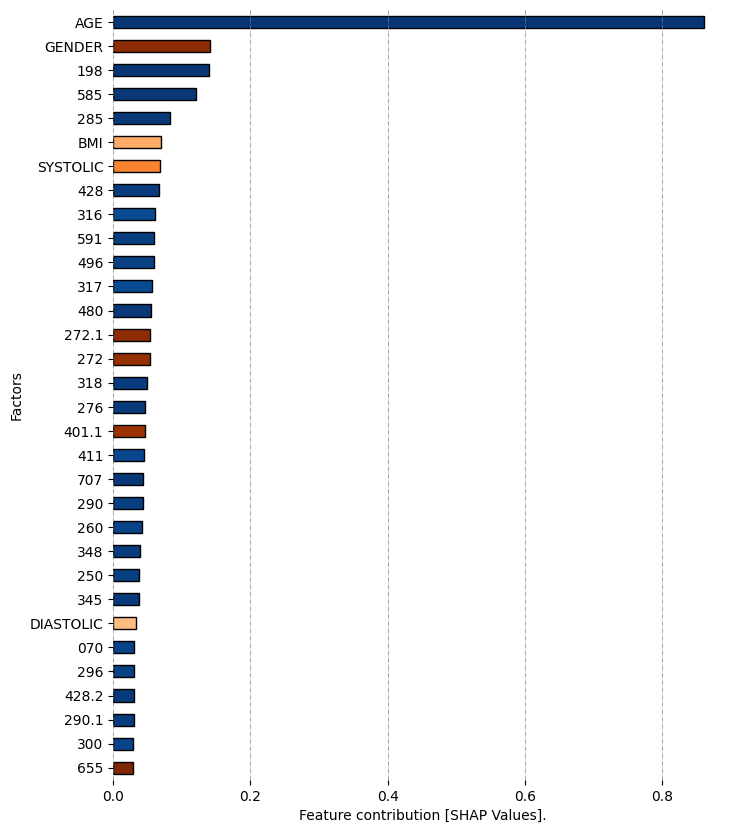

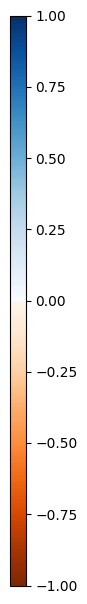

In [26]:
## feature importance plot

viridis = cm.get_cmap('viridis', 256)
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)), bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

def ABS_SHAP(feature_importance_value, correlation_coeff_value, top, colors):

    correlation_coeff_value_ = {}
    for key, value in correlation_coeff_value.items():
        correlation_coeff_value_[key] = np.mean(value)
    corr_df = pd.DataFrame.from_dict(correlation_coeff_value_, orient='index').fillna(0)
    corr_df.reset_index(inplace=True)
    corr_df.columns  = ['Variable','Corr']
    color_assigned = []
    for corr in list(corr_df['Corr']):
        if not np.isnan(corr):
            color_assigned.append(colors[int((corr+1)/2 * len(colors))])
        else:
            color_assigned.append([1,1,1,1])
    corr_df['Sign'] = color_assigned

    feature_importance_value_ = {}
    feature_importance_value_std = {}
    for key, value in feature_importance_value.items():
        feature_importance_value_[key] = np.mean(value)
        feature_importance_value_std[key] = np.std(value)

    feature_importance_std_df = pd.DataFrame.from_dict(feature_importance_value_std, orient='index').fillna(0)
    feature_importance_std_df.reset_index(inplace=True)
    feature_importance_std_df.columns = ['Variable','SHAP_std']

    feature_importance_df = pd.DataFrame.from_dict(feature_importance_value_, orient='index').fillna(0)
    feature_importance_df.reset_index(inplace=True)
    feature_importance_df.columns = ['Variable','SHAP_abs']

    feature_importance_df = feature_importance_df.merge(feature_importance_std_df, left_on='Variable',right_on='Variable',how='inner')

    k2 = feature_importance_df.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = False).head(top).iloc[::-1]
    print(list(k2['Variable']))
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,10),legend=False, xerr='SHAP_std', edgecolor='black')
    ax.set_xlabel("Feature contribution [SHAP Values].")
    ax.set_ylabel("Factors")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.grid(color='gray', linestyle='-.', linewidth=0.5)
#     plt.savefig('feature_imp_0.png', dpi=300) 
#     plt.savefig('feature_imp_0.png', dpi=300, bbox_inches='tight')

    fig, aaxx = plt.subplots(figsize=(0.2, 15))
    fig.subplots_adjust(bottom=0.5)
    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    cb1 = matplotlib.colorbar.ColorbarBase(aaxx, cmap=cmap,
                                norm=norm, orientation='vertical')
#     plt.savefig('feature_imp_1.png', dpi=300, bbox_inches='tight')
    
    return k2

ABS_SHAP(feature_importance_value, correlation_coeff_value, 32, newcolors) 

In [27]:
pd.read_csv('/data/chao/syn_mimic/preprocessing/original_testing_data.csv')

,WHITE,BLACK,ASIAN,HISPANIC,UN,OTHER,DIE_1y,GENDER,008,008.5,...,985,987,988,989,990,994,AGE,BMI,DIASTOLIC,SYSTOLIC
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53.0,24.7,78.0,114.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,33.5,85.0,118.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62.0,25.1,66.0,138.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,64.0,26.5,81.0,158.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,21.0,26.1,70.0,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54219,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,46.0,20.5,84.0,132.0
54220,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,28.0,23.3,63.0,110.0
54221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,86.0,23.5,74.0,126.0
54222,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,67.0,27.7,79.0,120.0


In [28]:
## Train on synthetic dataset and test on real testing data set

random.seed(a=2021, version=2)

RECALL_THRESHOLD = 0.6  # hold this to compute other threshold related metrics
LABEL_INDEX = 6  # label column index in the dataset
RACE_COL = [0,1,2,3,4,5]
COL_LIST = list(real_data_df.columns)[len(RACE_COL)+1:]
CAT_IDX_wo_RACE_label = list(np.linspace(0, len(COL_LIST) - 5, num=len(COL_LIST) - 4).astype(int))
## load the dataset for model evaluation. Here it is real data. 30%
eval_real_data = pd.read_csv('/data/chao/syn_mimic/preprocessing/original_testing_data.csv').values.astype(np.float)
eval_real_label = eval_real_data[:,LABEL_INDEX].astype(np.float)
eval_real_data = np.delete(eval_real_data, RACE_COL + [LABEL_INDEX], axis=1)
print('\nThe number of records in evaluation (real) data is: %d' % len(eval_real_data))
print('The number of features in training (real) data is: %d' % len(eval_real_data[0]))
print('Positive vs Negative ratio in evaluation (real) data is: %f' % (np.sum(eval_real_label)/len(eval_real_label)))


pred_result = []
correlation_result = []

real_auroc_result = []
real_prauc_result = []
real_acc_result = []
real_ppv_result = []
real_npv_result = []
real_sens_result = []
real_spes_result = []

print('\n   !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! ')

for run_ in range(len(model_id_list)):

    run = run_ + 1
    print('\n ######## Syn dataset %d ######## ' % run)
    syn_training_data = syn_data_list[run_]
    random.seed(a=2021, version=2)
    syn_training_data_index = np.linspace(0,len(syn_training_data)-1,len(syn_training_data)).astype('int')
    random.shuffle(syn_training_data_index)
    syn_training_data = syn_training_data[syn_training_data_index]
    syn_training_data_label = syn_training_data[:,LABEL_INDEX].astype(np.float)
    syn_training_data = np.delete(syn_training_data, [LABEL_INDEX]+RACE_COL, axis = 1)
    
    gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=syn_training_data, y=syn_training_data_label)

    param_grid = {
            'n_estimators': [500],
            'colsample_bytree': [0.9],
            'max_depth': [15],
            'num_leaves': [50],
            'reg_alpha': [1.3],
            'min_split_gain': [0.3],
            'subsample': [0.9],
            'subsample_freq': [40]
            }

    lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 20)
    gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
    gbm = gsearch.fit(X=syn_training_data, y=syn_training_data_label)
    print("Best parameters:\n")
    print(gbm.best_params_)

    y_scores = gbm.predict_proba(eval_real_data)
    y_scores = y_scores[:,1]
    tstr_auroc = roc_auc_score(y_score=y_scores, y_true=eval_real_label)
    tstr_prauc = average_precision_score(eval_real_label, y_scores)
    fpr, tpr, threshold_candidate = roc_curve(eval_real_label, y_scores)
    thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
    thres = threshold_candidate[thres_index]
    print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
    pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

    tn, fp, fn, tp = confusion_matrix(eval_real_label, pred_y).ravel()
    tstr_ppv = tp / (tp + fp)
    tstr_npv = tn / (tn + fn)
    tstr_sens = tp / (tp + fn)
    tstr_spes = tn / (tn + fp)
    tstr_acc = (tn + tp) / (tn + fp + fn + tp)
    print("      *** Test on real data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
    tstr_auroc, tstr_prauc, tstr_acc, tstr_ppv, tstr_npv, tstr_sens, tstr_spes))

    real_auroc_result.append(tstr_auroc)
    real_prauc_result.append(tstr_prauc)
    real_acc_result.append(tstr_acc)
    real_ppv_result.append(tstr_ppv)
    real_npv_result.append(tstr_npv)
    real_sens_result.append(tstr_sens)
    real_spes_result.append(tstr_spes)

    explainer = shap.TreeExplainer(gbm.best_estimator_)
#         shap_value_list.extend(explainer.shap_values(eval_real_data)[1])
    shap_df = pd.DataFrame(explainer.shap_values(eval_real_data)[1], columns = COL_LIST)
    shap_df_abs = abs(shap_df)

    feature_importance_mean = shap_df_abs.mean(axis=0).sort_values(ascending=False)
    feature_importance_value = {}
    for key, value in feature_importance_mean.items():
        if key in feature_importance_value.keys():
            feature_importance_value[key].append(value)
        else:
            feature_importance_value[key] = [value]
            
    np.save(f'./result/TSTR_feature_importance_run_{run}.npy', feature_importance_value)


print('TSTR AUROC: ', real_auroc_result)
utility_score['TSTR_auroc'] = real_auroc_result
        


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



The number of records in evaluation (real) data is: 54224
The number of features in training (real) data is: 1453
Positive vs Negative ratio in evaluation (real) data is: 0.113806

   !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! 

 ######## Syn dataset 1 ######## 


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
Threshold for fixing recall as 0.60 is 0.3291
      *** Test on real data AUROC: 0.9088, PRAUC: 0.5900, ACC: 0.8988, PPV: 0.5508, NPV: 0.9480, Sensitivity: 0.6001, Specificity: 0.9372


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



 ######## Syn dataset 2 ######## 


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
Threshold for fixing recall as 0.60 is 0.3605
      *** Test on real data AUROC: 0.9112, PRAUC: 0.6003, ACC: 0.9023, PPV: 0.5670, NPV: 0.9483, Sensitivity: 0.6002, Specificity: 0.9411


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



 ######## Syn dataset 3 ######## 


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
Threshold for fixing recall as 0.60 is 0.3318
      *** Test on real data AUROC: 0.9087, PRAUC: 0.5909, ACC: 0.8999, PPV: 0.5557, NPV: 0.9481, Sensitivity: 0.6002, Specificity: 0.9384


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



 ######## Syn dataset 4 ######## 


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
Threshold for fixing recall as 0.60 is 0.2881
      *** Test on real data AUROC: 0.9019, PRAUC: 0.5774, ACC: 0.8964, PPV: 0.5402, NPV: 0.9479, Sensitivity: 0.6002, Specificity: 0.9344


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



 ######## Syn dataset 5 ######## 


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
Threshold for fixing recall as 0.60 is 0.3396
      *** Test on real data AUROC: 0.9070, PRAUC: 0.5884, ACC: 0.8980, PPV: 0.5475, NPV: 0.9480, Sensitivity: 0.6001, Specificity: 0.9363


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


TSTR AUROC:  [0.9088399775509852, 0.9112225676327526, 0.9087195499710603, 0.9018799136073833, 0.9070287617218474]


In [29]:
feature_importance_value

{'AGE': [0.7898584848158935],
 '198': [0.12765535721165167],
 'GENDER': [0.11572255899786049],
 '285': [0.11391160295629499],
 '585': [0.10934835762970473],
 '649': [0.0961225400232341],
 '428': [0.07658341201831274],
 '401.1': [0.07022735778694185],
 '272': [0.06779697756089471],
 '655': [0.06686195615753952],
 '496': [0.06226784440881796],
 '418': [0.055959132520212465],
 '272.1': [0.049419131914214084],
 '300': [0.04677147822427735],
 '480': [0.0441623469925429],
 'DIASTOLIC': [0.04299587813792407],
 '707': [0.04274603939763557],
 '591': [0.04059909436112668],
 '348': [0.03720309180932708],
 '290': [0.03719343701393887],
 '509': [0.03548922892528432],
 '316': [0.03527110237700622],
 '290.1': [0.03524047547232238],
 '260': [0.03456582453164053],
 '278.1': [0.034217163862751004],
 '340': [0.034091913076503624],
 '1002': [0.0337487181328694],
 '296': [0.03238948131225675],
 'SYSTOLIC': [0.03234363194733314],
 '276': [0.032271017008907874],
 '427': [0.031159931397379763],
 '428.2': [0.0

## 1.g TRTS

In [30]:
## Train on real testing dataset and test on real training data set

random.seed(a=2021, version=2)

RECALL_THRESHOLD = 0.6  # hold this to compute other threshold related metrics
LABEL_INDEX = 6  # label column index in the dataset
RACE_COL = [0,1,2,3,4,5]
COL_LIST = list(real_data_df.columns)[len(RACE_COL)+1:]
CAT_IDX_wo_RACE_label = list(np.linspace(0, len(COL_LIST) - 5, num=len(COL_LIST) - 4).astype(int))

## Load the dataset for model training. Here it is real data. 70%
train_real_data = pd.read_csv('/data/chao/syn_mimic/preprocessing/original_testing_data.csv').values.astype(np.float)
train_real_data_index = np.linspace(0,len(train_real_data)-1,len(train_real_data)).astype('int')
random.shuffle(train_real_data_index)
train_real_data = train_real_data[train_real_data_index]
train_real_label = train_real_data[:,LABEL_INDEX].astype(np.float)
train_real_data = np.delete(train_real_data, [LABEL_INDEX]+RACE_COL, axis = 1)
print('The number of records in training (real) data is:  %d' % len(train_real_data))
print('The number of features in training (real) data is:  %d' % len(train_real_data[0]))
print('Positive vs Negative ratio in training (real) data is: %f' % (np.sum(train_real_label)/len(train_real_label)))

## load the dataset for model evaluation. Here it is real data. 30%
eval_real_data = pd.read_csv('/data/chao/syn_mimic/preprocessing/original_training_data.csv').values.astype(np.float)
eval_real_label = eval_real_data[:,LABEL_INDEX].astype(np.float)
eval_real_data = np.delete(eval_real_data, [LABEL_INDEX]+RACE_COL, axis=1)
print('\nThe number of records in evaluation (real) data is: %d' % len(eval_real_data))
print('The number of features in training (real) data is: %d' % len(eval_real_data[0]))
print('Positive vs Negative ratio in evaluation (real) data is: %f' % (np.sum(eval_real_label)/len(eval_real_label)))

## model training
print('\n !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! ')

gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_real_data, y=train_real_label)


# ############
# # try some candidates here

# param_grid = {
#     'n_estimators': [500, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15, 25],
#     'num_leaves': [20, 50],
#     'reg_alpha': [1.1, 1.3],
# #     'reg_lambda': [1.1, 1.3],
#     'min_split_gain': [0.3, 0.5],
#     'subsample': [0.8, 0.9],
#     'subsample_freq': [20]
#     }
############

param_grid = {
            'n_estimators': [500],
            'colsample_bytree': [0.9],
            'max_depth': [15],
            'num_leaves': [50],
            'reg_alpha': [1.3],
            'min_split_gain': [0.3],
            'subsample': [0.9],
            'subsample_freq': [40]
            }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 20)
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
gbm = gsearch.fit(X=train_real_data, y=train_real_label)
print("Best parameters:\n")
print(gbm.best_params_)

y_scores = gbm.predict_proba(eval_real_data)
y_scores = y_scores[:,1]
trtr_auroc = roc_auc_score(y_score=y_scores, y_true=eval_real_label)
trtr_prauc = average_precision_score(eval_real_label, y_scores)
fpr, tpr, threshold_candidate = roc_curve(eval_real_label, y_scores)
thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
thres = threshold_candidate[thres_index]
print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

tn, fp, fn, tp = confusion_matrix(eval_real_label, pred_y).ravel()
trtr_ppv = tp / (tp + fp)
trtr_npv = tn / (tn + fn)
trtr_sens = tp / (tp + fn)
trtr_spes = tn / (tn + fp)
trtr_acc = (tn + tp) / (tn + fp + fn + tp)
print("      *** Test on real data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
trtr_auroc, trtr_prauc, trtr_acc, trtr_ppv, trtr_npv, trtr_sens, trtr_spes))

explainer = shap.TreeExplainer(gbm.best_estimator_)
shap_df = pd.DataFrame(explainer.shap_values(eval_real_data)[1], columns = COL_LIST)
shap_df_abs = abs(shap_df)

feature_importance_mean = shap_df_abs.mean(axis=0).sort_values(ascending=False)
feature_importance_value = {}
for key, value in feature_importance_mean.items():
    if key in feature_importance_value.keys():
        feature_importance_value[key].append(value)
    else:
        feature_importance_value[key] = [value]

correlation_coeff_value = {}
for key in COL_LIST:
    corr_value = np.corrcoef(shap_df[key], eval_real_data[:, COL_LIST.index(key)])[1][0]
    if key in correlation_coeff_value.keys():
        correlation_coeff_value[key].append(corr_value)
    else:
        correlation_coeff_value[key] = [corr_value]

# np.save('./result/r_70_train_r_30_test_correl_coeff_value.npy', correlation_coeff_value)
# shap_df.to_csv('./result/r_70_train_r_30_test_feature_importance.csv')
# np.save('./result/r_70_train_r_30_test_y_estimate.npy', y_scores)
# np.save('./result/r_70_train_r_30_test_y_label.npy', eval_real_label)
# joblib.dump(gbm.best_estimator_, './result/r_70_train_r_30_test.pkl')

print('TRTR AUROC: %.4f' % trtr_auroc)
print('TRTR AUPRC: %.4f' % trtr_prauc)
print('TRTR ACCURACY: %.4f' % trtr_acc)
print('TRTR PPV: %.4f' % trtr_ppv)
print('TRTR NPV: %.4f' % trtr_npv)
print('TRTR RECALL: %.4f' % trtr_sens)
print('TRTR SPESIFICITY: %.4f' % trtr_spes)




`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The number of records in training (real) data is:  54224
The number of features in training (real) data is:  1453
Positive vs Negative ratio in training (real) data is: 0.113806


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



The number of records in evaluation (real) data is: 126522
The number of features in training (real) data is: 1453
Positive vs Negative ratio in evaluation (real) data is: 0.112573

 !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
Threshold for fixing recall as 0.60 is 0.3525
      *** Test on real data AUROC: 0.9183, PRAUC: 0.6251, ACC: 0.9089, PPV: 0.5943, NPV: 0.9492, Sensitivity: 0.6000, Specificity: 0.9480


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide


TRTR AUROC: 0.9183
TRTR AUPRC: 0.6251
TRTR ACCURACY: 0.9089
TRTR PPV: 0.5943
TRTR NPV: 0.9492
TRTR RECALL: 0.6000
TRTR SPESIFICITY: 0.9480


In [31]:
## Train on real testing dataset and test on synthetic training data set

random.seed(a=2021, version=2)

train_real_data = pd.read_csv('/data/chao/syn_mimic/preprocessing/original_testing_data.csv').values.astype(np.float)
train_real_data_index = np.linspace(0,len(train_real_data)-1,len(train_real_data)).astype('int')
random.shuffle(train_real_data_index)
train_real_data = train_real_data[train_real_data_index]
train_real_label = train_real_data[:,LABEL_INDEX].astype(np.float)
train_real_data = np.delete(train_real_data, [LABEL_INDEX]+RACE_COL, axis = 1)
print('The number of records in training (real) data is:  %d' % len(train_real_data))
print('The number of features in training (real) data is:  %d' % len(train_real_data[0]))
print('Positive vs Negative ratio in training (real) data is: %f' % (np.sum(train_real_label)/len(train_real_label)))

gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_real_data, y=train_real_label)

param_grid = {
            'n_estimators': [500],
            'colsample_bytree': [0.9],
            'max_depth': [15],
            'num_leaves': [50],
            'reg_alpha': [1.3],
            'min_split_gain': [0.3],
            'subsample': [0.9],
            'subsample_freq': [40]
            }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 20)

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
gbm = gsearch.fit(X=train_real_data, y=train_real_label)
print("Best parameters:\n")
print(gbm.best_params_)

print('\n   !!!!!!!!!!!!!!!!!!! evaluation is starting !!!!!!!!!!!!!!!!!!! ')

syn_auroc_result = []
syn_prauc_result = []
syn_acc_result = []
syn_ppv_result = []
syn_npv_result = []
syn_sens_result = []
syn_spes_result = []

for run_ in range(len(model_id_list)):

    run = run_ + 1
    print('\n ######## Syn dataset %d ######## ' % run)
    
    syn_data = syn_data_list[run_]
    random.seed(a=2021, version=2)
    syn_data_index = np.linspace(0,len(syn_data)-1,len(syn_data)).astype('int')
    random.shuffle(syn_data_index)
    syn_data = syn_data[syn_data_index]
    syn_label = syn_data[:,LABEL_INDEX].astype(np.float)
    syn_data = np.delete(syn_data, [LABEL_INDEX]+RACE_COL, axis = 1)

    y_scores = gbm.best_estimator_.predict_proba(syn_data)
    y_scores = y_scores[:,1]
    auroc = roc_auc_score(y_score=y_scores, y_true=syn_label)
    prauc = average_precision_score(syn_label, y_scores)
    fpr, tpr, threshold_candidate = roc_curve(syn_label, y_scores)
    thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
    thres = threshold_candidate[thres_index]
    print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
    pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

    tn, fp, fn, tp = confusion_matrix(syn_label, pred_y).ravel()
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    sens = tp / (tp + fn)
    spes = tn / (tn + fp)
    acc = (tn + tp) / (tn + fp + fn + tp)
    print("      *** Test on syn data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
    auroc, prauc, acc, ppv, npv, sens, spes))   

    syn_auroc_result.append(auroc)
    syn_prauc_result.append(prauc)
    syn_acc_result.append(acc)
    syn_ppv_result.append(ppv)
    syn_npv_result.append(npv)
    syn_sens_result.append(sens)
    syn_spes_result.append(spes)


print('TRTS AUROC: ', syn_auroc_result)
utility_score['TRTS_auroc'] = syn_auroc_result
    

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The number of records in training (real) data is:  54224
The number of features in training (real) data is:  1453
Positive vs Negative ratio in training (real) data is: 0.113806


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}

   !!!!!!!!!!!!!!!!!!! evaluation is starting !!!!!!!!!!!!!!!!!!! 

 ######## Syn dataset 1 ######## 


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Threshold for fixing recall as 0.60 is 0.3101
      *** Test on syn data AUROC: 0.9024, PRAUC: 0.5934, ACC: 0.8958, PPV: 0.5332, NPV: 0.9484, Sensitivity: 0.6000, Specificity: 0.9334

 ######## Syn dataset 2 ######## 


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Threshold for fixing recall as 0.60 is 0.2967
      *** Test on syn data AUROC: 0.9031, PRAUC: 0.5879, ACC: 0.8954, PPV: 0.5316, NPV: 0.9484, Sensitivity: 0.6001, Specificity: 0.9329

 ######## Syn dataset 3 ######## 


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Threshold for fixing recall as 0.60 is 0.3013
      *** Test on syn data AUROC: 0.9013, PRAUC: 0.5859, ACC: 0.8937, PPV: 0.5243, NPV: 0.9483, Sensitivity: 0.6000, Specificity: 0.9309

 ######## Syn dataset 4 ######## 


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Threshold for fixing recall as 0.60 is 0.2500
      *** Test on syn data AUROC: 0.8738, PRAUC: 0.5315, ACC: 0.8739, PPV: 0.4546, NPV: 0.9471, Sensitivity: 0.6000, Specificity: 0.9087

 ######## Syn dataset 5 ######## 


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Threshold for fixing recall as 0.60 is 0.2652
      *** Test on syn data AUROC: 0.8949, PRAUC: 0.5687, ACC: 0.8896, PPV: 0.5082, NPV: 0.9481, Sensitivity: 0.6001, Specificity: 0.9263
TRTS AUROC:  [0.9024328980257994, 0.9030885875518126, 0.9013117821936679, 0.8738215730374622, 0.8949010115526643]


## 1.h feature importance

In [32]:
# Load the real dataset for model training.

random.seed(a=2021, version=2)

RECALL_THRESHOLD = 0.6  # hold this to compute other threshold related metrics
LABEL_INDEX = 6  # label column index in the dataset
RACE_COL = [0,1,2,3,4,5]
# CAT_IDX_wo_RACE_label = list(np.linspace(0, len(COL_LIST) - 5, num=len(COL_LIST) - 4).astype(int))


feature_importance_TRTR = np.load('./result/feature_importance_TRTR.npy', allow_pickle=True).item()
COL_LIST = list(real_data_df.columns)[len(RACE_COL)+1:]
top_feature_indices = [COL_LIST.index(name) for name in list(feature_importance_TRTR.keys())]
cat_or_not = [0,1,1,1,1,0,0] + [1]*18 + [0] + [1]*(len(COL_LIST)-26) # indicate mannually the binary features

train_real_data = pd.read_csv('/data/chao/syn_mimic/preprocessing/original_training_data.csv').values.astype(np.float)
train_real_data_index = np.linspace(0,len(train_real_data)-1,len(train_real_data)).astype('int')
random.shuffle(train_real_data_index)
train_real_data = train_real_data[train_real_data_index]
train_real_label = train_real_data[:,LABEL_INDEX].astype(np.float)
train_real_data = np.delete(train_real_data, [LABEL_INDEX]+RACE_COL, axis = 1)
print('The number of records in training (real) data is:  %d' % len(train_real_data))
print('The number of features in training (real) data is:  %d' % len(train_real_data[0]))
print('Positive vs Negative ratio in training (real) data is: %f' % (np.sum(train_real_label)/len(train_real_label)))

## load the dataset for model evaluation. Here it is real data. 30%
eval_real_data = pd.read_csv('/data/chao/syn_mimic/preprocessing/original_testing_data.csv').values.astype(np.float)
eval_real_label = eval_real_data[:,LABEL_INDEX].astype(np.float)
eval_real_data = np.delete(eval_real_data, [LABEL_INDEX]+RACE_COL, axis=1)
print('\nThe number of records in evaluation (real) data is: %d' % len(eval_real_data))
print('The number of features in training (real) data is: %d' % len(eval_real_data[0]))
print('Positive vs Negative ratio in evaluation (real) data is: %f' % (np.sum(eval_real_label)/len(eval_real_label)))

## model training
print('\n !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! ')

test_candidates = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
auroc_performance = {}
auprc_performance = {}

for num_features in test_candidates:
    print('Testing top %d features: ' % num_features)

    selected_feature_indices = top_feature_indices[:num_features]
    selected_feature_cat_or_not = cat_or_not[:num_features]
    cat_indices = [i for i in range(len(selected_feature_cat_or_not)) if selected_feature_cat_or_not[i] == 1]
    
    gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_real_data, y=train_real_label)

    param_grid = {
            'n_estimators': [500],
            'colsample_bytree': [0.9],
            'max_depth': [15],
            'num_leaves': [50],
            'reg_alpha': [1.3],
            'min_split_gain': [0.3],
            'subsample': [0.9],
            'subsample_freq': [40]
            }

    lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=cat_indices, n_jobs = 20)

    gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
    gbm = gsearch.fit(X=train_real_data[:, selected_feature_indices], y=train_real_label)
    print("Best parameters:\n")
    print(gbm.best_params_)

    y_scores = gbm.predict_proba(eval_real_data[:, selected_feature_indices])
    y_scores = y_scores[:,1]
    auroc = roc_auc_score(y_score=y_scores, y_true=eval_real_label)
    prauc = average_precision_score(eval_real_label, y_scores)
    fpr, tpr, threshold_candidate = roc_curve(eval_real_label, y_scores)
    thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
    thres = threshold_candidate[thres_index]
    print("      Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
    pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

    tn, fp, fn, tp = confusion_matrix(eval_real_label, pred_y).ravel()
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    sens = tp / (tp + fn)
    spes = tn / (tn + fp)
    acc = (tn + tp) / (tn + fp + fn + tp)
    print("      *** Test on real data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
    auroc, prauc, acc, ppv, npv, sens, spes))
    
    auroc_performance[num_features] = auroc
    auprc_performance[num_features] = prauc
    
np.save('./result/auroc_performance_feature_imp.npy', auroc_performance)
np.save('./result/auprc_performance_feature_imp.npy', auprc_performance)
    

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The number of records in training (real) data is:  126522
The number of features in training (real) data is:  1453
Positive vs Negative ratio in training (real) data is: 0.112573


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.



The number of records in evaluation (real) data is: 54224
The number of features in training (real) data is: 1453
Positive vs Negative ratio in evaluation (real) data is: 0.113806

 !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! 
Testing top 5 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.2161
      *** Test on real data AUROC: 0.8548, PRAUC: 0.4680, ACC: 0.8541, PPV: 0.4050, NPV: 0.9454, Sensitivity: 0.6012, Specificity: 0.8866
Testing top 10 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.2374
      *** Test on real data AUROC: 0.8676, PRAUC: 0.5020, ACC: 0.8660, PPV: 0.4355, NPV: 0.9460, Sensitivity: 0.6001, Specificity: 0.9001
Testing top 15 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.2519
      *** Test on real data AUROC: 0.8760, PRAUC: 0.5163, ACC: 0.8718, PPV: 0.4525, NPV: 0.9464, Sensitivity: 0.6001, Specificity: 0.9067
Testing top 20 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.2583
      *** Test on real data AUROC: 0.8799, PRAUC: 0.5281, ACC: 0.8764, PPV: 0.4664, NPV: 0.9467, Sensitivity: 0.6002, Specificity: 0.9118
Testing top 25 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.2706
      *** Test on real data AUROC: 0.8874, PRAUC: 0.5395, ACC: 0.8803, PPV: 0.4794, NPV: 0.9469, Sensitivity: 0.6001, Specificity: 0.9163
Testing top 30 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.2864
      *** Test on real data AUROC: 0.8918, PRAUC: 0.5501, ACC: 0.8860, PPV: 0.4992, NPV: 0.9473, Sensitivity: 0.6001, Specificity: 0.9227
Testing top 35 features: 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.2926
      *** Test on real data AUROC: 0.8945, PRAUC: 0.5555, ACC: 0.8867, PPV: 0.5020, NPV: 0.9474, Sensitivity: 0.6004, Specificity: 0.9235
Testing top 40 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3047
      *** Test on real data AUROC: 0.9001, PRAUC: 0.5703, ACC: 0.8919, PPV: 0.5219, NPV: 0.9476, Sensitivity: 0.6001, Specificity: 0.9294
Testing top 45 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3203
      *** Test on real data AUROC: 0.9052, PRAUC: 0.5878, ACC: 0.8970, PPV: 0.5428, NPV: 0.9480, Sensitivity: 0.6004, Specificity: 0.9351
Testing top 50 features: 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3244
      *** Test on real data AUROC: 0.9071, PRAUC: 0.5932, ACC: 0.8979, PPV: 0.5470, NPV: 0.9480, Sensitivity: 0.6002, Specificity: 0.9362
Testing top 55 features: 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3354
      *** Test on real data AUROC: 0.9101, PRAUC: 0.6010, ACC: 0.9012, PPV: 0.5618, NPV: 0.9482, Sensitivity: 0.6001, Specificity: 0.9399
Testing top 60 features: 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3405
      *** Test on real data AUROC: 0.9112, PRAUC: 0.6044, ACC: 0.9027, PPV: 0.5688, NPV: 0.9483, Sensitivity: 0.6001, Specificity: 0.9416
Testing top 65 features: 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3437
      *** Test on real data AUROC: 0.9118, PRAUC: 0.6074, ACC: 0.9034, PPV: 0.5719, NPV: 0.9483, Sensitivity: 0.6001, Specificity: 0.9423
Testing top 70 features: 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3434
      *** Test on real data AUROC: 0.9126, PRAUC: 0.6094, ACC: 0.9034, PPV: 0.5722, NPV: 0.9483, Sensitivity: 0.6001, Specificity: 0.9424
Testing top 75 features: 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3463
      *** Test on real data AUROC: 0.9131, PRAUC: 0.6106, ACC: 0.9039, PPV: 0.5746, NPV: 0.9483, Sensitivity: 0.6001, Specificity: 0.9429
Testing top 80 features: 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3561
      *** Test on real data AUROC: 0.9154, PRAUC: 0.6141, ACC: 0.9061, PPV: 0.5855, NPV: 0.9485, Sensitivity: 0.6004, Specificity: 0.9454
Testing top 85 features: 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3558
      *** Test on real data AUROC: 0.9164, PRAUC: 0.6156, ACC: 0.9063, PPV: 0.5863, NPV: 0.9485, Sensitivity: 0.6004, Specificity: 0.9456
Testing top 90 features: 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3578
      *** Test on real data AUROC: 0.9171, PRAUC: 0.6191, ACC: 0.9070, PPV: 0.5896, NPV: 0.9485, Sensitivity: 0.6001, Specificity: 0.9464
Testing top 95 features: 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3617
      *** Test on real data AUROC: 0.9173, PRAUC: 0.6197, ACC: 0.9077, PPV: 0.5936, NPV: 0.9486, Sensitivity: 0.6001, Specificity: 0.9472
Testing top 100 features: 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.9, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'subsample': 0.9, 'subsample_freq': 40}
      Threshold for fixing recall as 0.60 is 0.3596
      *** Test on real data AUROC: 0.9176, PRAUC: 0.6203, ACC: 0.9074, PPV: 0.5921, NPV: 0.9486, Sensitivity: 0.6001, Specificity: 0.9469


In [33]:
auroc_performance

{5: 0.8548187638775113,
 10: 0.8676462233405431,
 15: 0.8759855255295728,
 20: 0.8798640837289451,
 25: 0.887421965678305,
 30: 0.8917697398907596,
 35: 0.8945005704097798,
 40: 0.9000728001598922,
 45: 0.9052191106317841,
 50: 0.9070682309160856,
 55: 0.9101274913988838,
 60: 0.9112054785912451,
 65: 0.9118406243918615,
 70: 0.9125531303527502,
 75: 0.9131148278407805,
 80: 0.9153664098063169,
 85: 0.9163834227590145,
 90: 0.9170942425786593,
 95: 0.9172876969358594,
 100: 0.9175802323248363}

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


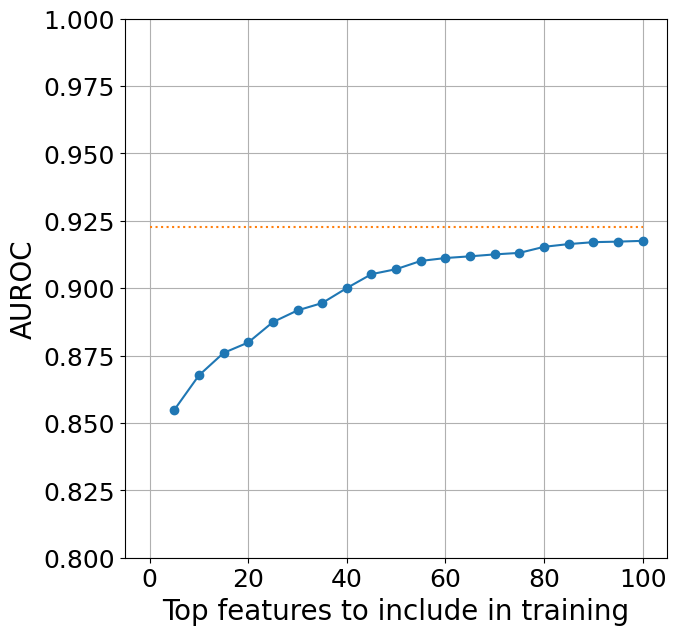

In [34]:
font = {'family' : 'normal', 'size'  : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(7, 7)) 
plt.xlabel("Top features to include in training", fontsize=20)
plt.ylabel("AUROC", fontsize=20)
plt.ylim(0.8, 1.0)
df = pd.DataFrame(auroc_performance.items(), columns=['x_axis', 'y_axis'])
plt.plot('x_axis', 'y_axis', data=df, linestyle='-', marker='o')
plt.plot([0, 100], [trtr_7_3_auroc, trtr_7_3_auroc], linestyle=':')  ## the performance of training on 70% real data and testing on 30% testing data
plt.grid()
plt.show()

In [35]:
for n, auroc in auroc_performance.items():
    print(n, auroc, auroc/trtr_7_3_auroc)

## select 95% performance as the threshold, thus 20 is the number of important features to achieve this.

5 0.8548187638775113 0.9264413757795213
10 0.8676462233405431 0.940343608270045
15 0.8759855255295728 0.9493816347143884
20 0.8798640837289451 0.9535851652709337
25 0.887421965678305 0.9617762986983084
30 0.8917697398907596 0.9664883594217933
35 0.8945005704097798 0.9694479977568081
40 0.9000728001598922 0.9754871073482225
45 0.9052191106317841 0.9810646112066325
50 0.9070682309160856 0.9830686635421233
55 0.9101274913988838 0.9863842499685318
60 0.9112054785912451 0.987552558362973
65 0.9118406243918615 0.9882409210594988
70 0.9125531303527502 0.9890131256840938
75 0.9131148278407805 0.9896218860618167
80 0.9153664098063169 0.9920621210940589
85 0.9163834227590145 0.9931643464064852
90 0.9170942425786593 0.9939347236132934
95 0.9172876969358594 0.994144386910835
100 0.9175802323248363 0.9944614329323783


In [52]:
feature_imp_score = []
TRTR_top_features = set(list(feature_importance_TRTR.keys())[:20])
for run in range(len(syn_data_list)):
    run += 1
    feature_importance_value = np.load(f'./result/TSTR_feature_importance_run_{run}.npy', allow_pickle=True).item()
    syn_top_imp_features = []
    for key, imp in feature_importance_value.items():
        syn_top_imp_features.append(key)
        if len(syn_top_imp_features) == 20:
            syn_top_imp_features = set(syn_top_imp_features)
            intersection_imp_features = TRTR_top_features.intersection(syn_top_imp_features)
            feature_imp_score.append(len(intersection_imp_features)/len(TRTR_top_features))
            break
utility_score['Feature importance'] = feature_imp_score
feature_imp_score

[0.7, 0.8, 0.65, 0.65, 0.65]

In [56]:
np.save('./result/utility_score.npy', utility_score)

## 2. Rank datasets and derive scores for selection

In [55]:
utility_score

{'Dimension-wise distribution': [1.024415873644543,
  0.5235392767153383,
  1.5588431385697294,
  1.2745413222278763,
  0.8537903943627151],
 'Column-wise correlation': [5.800565453515808,
  5.4226583129816746,
  5.9071028272186075,
  6.3210266094586265,
  6.315851456601387],
 'Latent cluster analysis': [-11.098742322050022,
  -15.663163969433555,
  -9.92536962270512,
  -8.358865094374572,
  -9.372114175598648],
 'Medical concept abundance': [0.046229114304231676,
  0.026556646274956134,
  0.06971910023553216,
  0.05911224925309432,
  0.022557341806168096],
 'Clinical knowledge violation': array([0.0431216 , 0.05790536, 0.04047659, 0.05680659, 0.06371215]),
 'TSTR_auroc': [0.9088399775509852,
  0.9112225676327526,
  0.9087195499710603,
  0.9018799136073833,
  0.9070287617218474],
 'TRTS_auroc': [0.9024328980257994,
  0.9030885875518126,
  0.9013117821936679,
  0.8738215730374622,
  0.8949010115526643],
 'Feature importance': [0.7, 0.8, 0.65, 0.65, 0.65]}

In [64]:
dataset_ranks = {}
for metric, score in utility_score.items():
    if metric not in ['TSTR_auroc', 'TRTS_auroc', 'Feature importance']:
        ranks = ss.rankdata(score).astype(int)
        dataset_ranks[metric] = list(ranks)
    else:
        ranks = len(syn_data_list) + 1 - ss.rankdata(score).astype(int)
        dataset_ranks[metric] = list(ranks)
    print(metric, ranks)
np.save('./result/utility_score_dataset_ranks.npy', dataset_ranks)
dataset_ranks

Dimension-wise distribution [3 1 5 4 2]
Column-wise correlation [2 1 3 5 4]
Latent cluster analysis [2 1 3 5 4]
Medical concept abundance [3 2 5 4 1]
Clinical knowledge violation [2 4 1 3 5]
TSTR_auroc [2 1 3 5 4]
TRTS_auroc [2 1 3 5 4]
Feature importance [2 1 4 4 4]
